# DVL-NAV -- Unit 770
02/11/2022
Gregory Burgess

---

1. [Import Libraries](#import-libraries)
1. [Load and Parse Data](#load-and-parse-data)
    1. [Bathymetry Data](#import-bathymetry)
    1. [Glider Flight Computer Data](#import-glider-flight-computer)
    1. [Rosbag Data](#import-rosbag-data)
    1. [Separate and Select Dives](#separate-and-select-dives)
    1. [DVL Data](#import-dvl-data)
1. [Compute Water Column Currents](#compute-water-column-currents)
1. [Compute DVL-Odometry](#compute-dvl-odometry)
1. [Multi-Factor Terrain Based Navigation](#multi-factor-terrain-based-navigation)
    1. [Plot Navigation Results](#plot-navigation-results)
    1. [Navigation Performance](#navigation-performance)
        2. [Print Performance metrics](#print_metrics)
1. [Sandbox](#sandbox)


Bin number to 20 --- why did i do this again and do i want 40 for puerto rico

dvl ensemble coordinate frame

---
<a id='import-libraries'></a>
## Import Libraries

In [3]:
import datetime
import earthpy as et
import earthpy.plot as ep
import importlib
import numpy as np
import os
import pandas as pd
import rasterio as rio
import scipy
import scipy.signal
import seaborn as sns 
import struct
import sys
import utm
import unittest
from PIL import Image
from matplotlib import pyplot as plt 
from os import listdir
from os.path import isfile, join
from scipy.spatial.transform import Rotation as R
from scipy import interpolate

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
sys.path.append(os.path.join(sys.path[0], '../data'))

# objects for parsing raw DVL data 
import PathfinderDVL
import PathfinderEnsemble
import PathfinderTimeSeries

# objects for estimating ocean current velocities
import VelocityShearPropagation

# objects for controlling thruster to minimize transport cost 
import AdaptiveVelocityController

# objects for parsing flight and science computer log files
import SlocumFlightController
import SlocumScienceController
import dvl_plotter
import BathymetryMap
import MultiFactorTAN

# data for parsing seafloor bathymetry
import bathy_meta_data
sns.set()


import warnings
warnings.simplefilter('ignore')

def reload_modules():
    importlib.reload(PathfinderDVL)
    importlib.reload(PathfinderEnsemble)
    importlib.reload(PathfinderTimeSeries)
    importlib.reload(VelocityShearPropagation)
    importlib.reload(AdaptiveVelocityController)
    importlib.reload(SlocumFlightController)
    importlib.reload(SlocumScienceController)
    importlib.reload(dvl_plotter)
    importlib.reload(bathy_meta_data)
    importlib.reload(BathymetryMap)
    importlib.reload(MultiFactorTAN)
print('Done!')

#TODO
#pip3 install utm threw error --> is this code all designed for python2???

Done!


In [1]:
#filepath = '/home/gburgess/dvl-nav/data/field_data/buzz_bay/dec_15/'
filepath = '/home/gburgess/dvl-nav/data/field_data/puerto_rico/mar7/'

---
<a id='load-and-parse-data'></a>
## Load and Parse Data
<a id='import-bathymetry'></a>
### Bathymetry Data

In [5]:
# #TODO
# reload_modules()
# #Grid_res_num should always be 10 to represent original resolution of the bathymetry chart. Then, the Minimum spatial resolution will be 5m
# #directory = "/mnt/c/Users/User/Dropbox (MIT)/Kolumbo cruise 2019/zduguid/dbd-parsed/sentinel_2019-Nov/
# #10m resolution
# #bathy_df = pd.read_csv('/mnt/c/Users/User/Dropbox (MIT)/Kolumbo cruise 2019/zduguid/bathy/sensitivity_tests/Kolumbo-1.csv')
# bathy_df = pd.read_csv('/home/gburgess/dvl-nav/data/field_data/kolumbo/bathy/Kolumbo-1.csv')
# grid_res_num = 10
# # map_var_resolution = '10m'

# #20m resolution
# #bathy_df_var = pd.read_csv('/mnt/c/Users/User/Dropbox (MIT)/Kolumbo cruise 2019/zduguid/bathy/sensitivity_tests/Kolumbo-2.csv')
# bathy_df_var = pd.read_csv('/home/gburgess/dvl-nav/data/field_data/kolumbo/bathy/Kolumbo-2.csv')
# map_var_resolution = '20m'
# # grid_res_num = 20

<a id='import-glider-flight-computer'></a>
### Glider Flight Computer Data

In [4]:
reload_modules()
directory = filepath+'dbd_parsed/'
ts_flight = SlocumFlightController.SlocumFlightController.from_directory(directory, save=False, verbose=False)
#ts_flight.df.to_csv(filepath+'ts_flight.csv', sep=',' , index=False)

>> Parsing folder of ASC Files
>> Finished Parsing!


In [119]:
ts_flight.df.head()


,time,m_filename_hash,m_mission_hash,m_present_time,m_speed,m_pitch,m_roll,m_heading,m_fin,m_depth,...,u_mission_param_g,u_mission_param_h,u_mission_param_i,u_mission_param_j,u_mission_param_k,u_mission_param_l,u_mission_param_m,u_mission_param_n,u_mission_mode,sci_mission_mode
2022-03-07 11:29:24.512080,1.646667e+09,-3.279447e+17,-4.314876e+18,1.646649e+09,0.0,0.218166,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-07 11:29:44.616360,1.646667e+09,-3.279447e+17,-4.314876e+18,1.646649e+09,NaN,0.216421,0.000000,0.00000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2022-03-07 11:29:59.726810,1.646667e+09,-3.279447e+17,-4.314876e+18,1.646649e+09,NaN,1.640610,0.000000,0.00000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2022-03-07 13:04:21.475100,1.646673e+09,5.876992e+18,-5.184777e+18,1.646655e+09,0.0,0.000000,0.094248,2.63196,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-07 13:04:36.475620,1.646673e+09,5.876992e+18,-5.184777e+18,1.646655e+09,NaN,0.000000,0.094248,2.63196,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


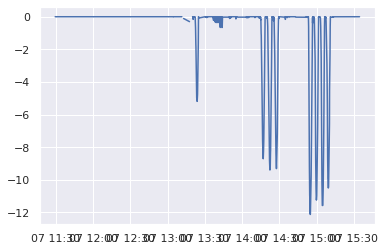

In [127]:
plt.figure()
#plt.plot(ts_flight.df.m_pitch*180/3.14)
plt.plot(ts_flight.df.m_depth*-1)

<a id='import-rosbag-data'></a>
### Rosbag Data

In [114]:
# CTD Sensor
#ctd_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'ctd-data.csv')

# IMU Sensor
ahrs_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-spartonm2-ahrs.csv')

# # DVL Sensor
# dvl_df        = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-dvl.csv')
# dvl_pd0_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-pd0.csv')
# dvl_ranges_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-ranges.csv')
# dvl_raw_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-instrument-raw.csv')

# EXTCTL - GLider 
m_lon_df        = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_lon.csv')
m_lat_df        = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_lat.csv')
m_gps_lon_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_gps_lon.csv')
m_gps_lat_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_gps_lat.csv')
m_depth_df      = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_depth.csv')
m_pitch_df      = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_pitch.csv')
m_roll_df       = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_roll.csv')
m_altitude_df   = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_altitude.csv')
m_alt_status_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_altimeter_status.csv')

# Micron Sonar



<a id='separate-and-select-dives'></a>
### Separate and Select Dives

In [5]:
ctd_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'ctd-data.csv')

# Use CTD to determine start and end points of dives
dive_dic = {}
dive_dic['dive1'] = [0]
count = 0
for i in range(1,len(ctd_df.Time)):
    dt = ctd_df.Time[i] - ctd_df.Time[i-1]
    if dt > 5.0:
        count += 1
        dive_dic['dive'+str(count)].append(i-1)
        dive_dic['dive'+str(count+1)] = [i]

# Pop off last entry (will only have one idx)
for key in dive_dic:
    if len(dive_dic[key]) < 2:
        last = key
dive_dic.pop(last)

# Create DateTime Column to make it easier to read
#ctd_df['Time'] = pd.to_datetime(ctd_df['header.stamp.secs'], unit='s')
ctd_df['Time_easy'] = (ctd_df['Time'] - ctd_df.Time[0])/60

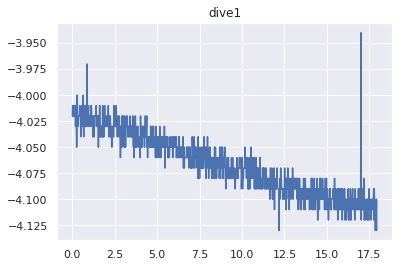

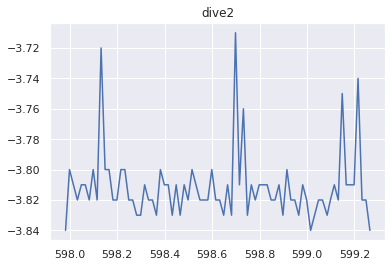

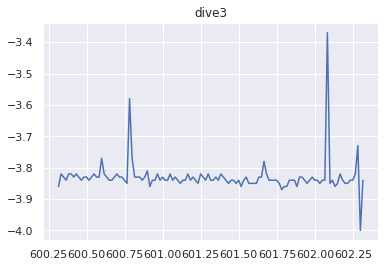

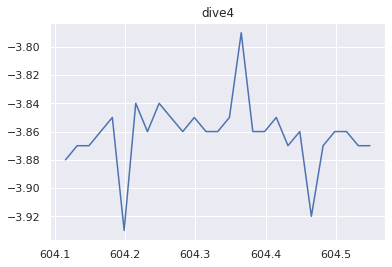

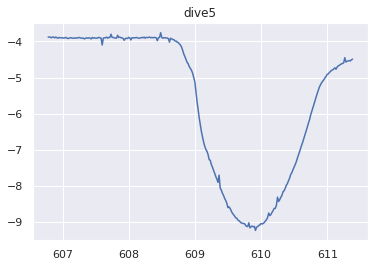

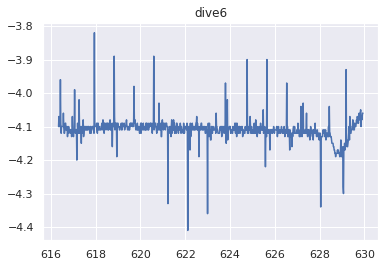

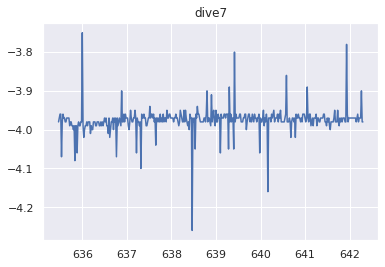

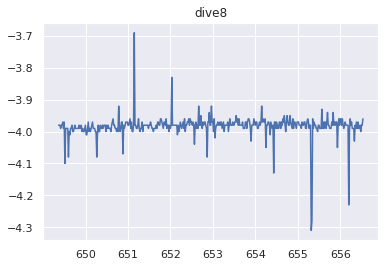

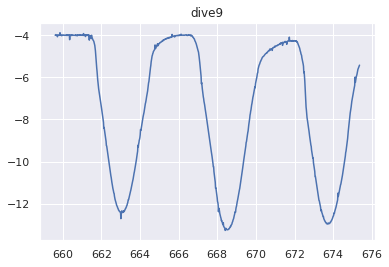

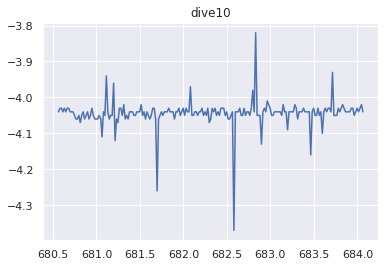

In [6]:
for key in dive_dic:
    plt.figure()
    plt.plot(ctd_df.Time_easy[dive_dic[key][0]:dive_dic[key][1]], ctd_df.depth[dive_dic[key][0]:dive_dic[key][1]]*-1)
    plt.title(key)

### Select Dive

In [9]:
selected_dive = 'dive9'

In [17]:
ctd_start = ctd_df.Time[dive_dic[selected_dive][0]]
ctd_end = ctd_df.Time[dive_dic[selected_dive][1]]
print(start_idx, end_idx)

time_zone_shift = 3600*5

start_t = datetime.datetime.fromtimestamp(ctd_start+time_zone_shift)
end_t   = datetime.datetime.fromtimestamp(ctd_end+time_zone_shift)
dur     = end_t - start_t 
print(start_t, end_t)

df_dbd  = ts_flight.df[str(start_t):str(end_t)].copy()

1646658834.4313526 1646659780.405643
2022-03-07 14:13:54.431353 2022-03-07 14:29:40.405643


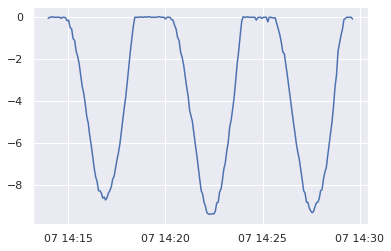

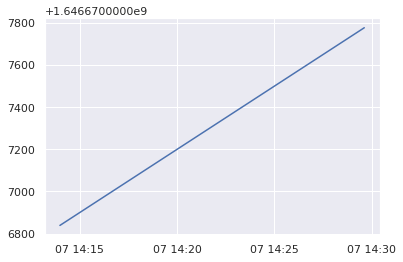

In [30]:
plt.figure()
plt.plot(df_dbd.m_depth*-1)

plt.figure()
# plt.plot(ts.df.time)
plt.plot(df_dbd.time)


<a id='import-dvl-data'></a>
### DVL Data

In [26]:
# DVL Sensor
dvl_df        = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-dvl.csv')
dvl_pd0_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-pd0.csv')
dvl_ranges_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-ranges.csv')
dvl_raw_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-instrument-raw.csv')

In [27]:
reload_modules()
# Initialize Timseries object
ts = PathfinderTimeSeries.PathfinderTimeSeries()
prev_ensemble = None
error_count = 0
# for i in range(0,len(dvl_raw_df.data)):
for i in range(0,len(dvl_raw_df.data)):
    try:
        ensemble_raw = dvl_raw_df.data[i][2:-1]
        ensemble_bytes = ensemble_raw.encode().decode('unicode_escape').encode("raw_unicode_escape")
        ensemble = PathfinderEnsemble.PathfinderEnsemble(ensemble_bytes, prev_ensemble)
        ts.add_ensemble(ensemble)
        prev_ensemble = ensemble
    except:
        error_count += 1
        continue
ts.to_dataframe()
print('Error Count: ' + str(error_count))

Error Count:  4


In [19]:
ts.df.head()


,time,system_configuration,num_beams,num_bins,pings_per_ensemble,depth_bin_length,blanking_distance,low_correlation_threshold,percent_good_minimum,error_velocity_threshold,...,btm_beam2_range,btm_beam3_range,btm_beam0_velocity,btm_beam1_velocity,btm_beam2_velocity,btm_beam3_velocity,btm_beam0_rssi,btm_beam1_rssi,btm_beam2_rssi,btm_beam3_rssi
2004-01-01 00:00:12,1.072930e+09,16971.0,4.0,20.0,1.0,2.0,0.0,64.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2004-01-01 00:00:13,1.072930e+09,16971.0,4.0,20.0,1.0,2.0,0.0,64.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2004-01-01 00:00:14,1.072930e+09,16971.0,4.0,20.0,1.0,2.0,0.0,64.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2004-01-01 00:00:15,1.072930e+09,16971.0,4.0,20.0,1.0,2.0,0.0,64.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2004-01-01 00:00:16,1.072930e+09,16971.0,4.0,20.0,1.0,2.0,0.0,64.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


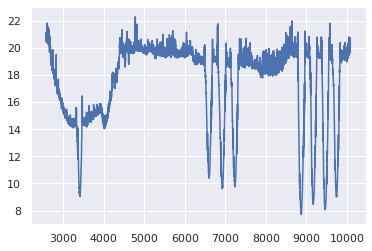

In [133]:
dvl_df.head()
plt.figure()
plt.plot(dvl_df.altitude)

---
<a id='compute-water-column-currents'></a>
## Compute Water Column Currents


In [ ]:
#TODO

---
<a id='compute-dvl-odometry'></a>
## Compute DVL-Odometry

In [2]:
#TODO

---
## Plot Navigation Results 

In [4]:
#TODO